In [1]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
# Import Numpy
import numpy as np
# Plot Import
import matplotlib.pyplot as plt
# For timer
import time
# Import OS
import os
# import local libs
import ecg_tools_lite as et

if not os.path.exists('./mlp_img'):
    os.mkdir('./mlp_img')

In [2]:
device = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device, time.localtime().tm_mon, "/", time.localtime().tm_mday, "/", time.localtime().tm_year)

Device: cuda 11 / 14 / 2020


In [3]:
ecg_clean = et.load_ecg_file('all_chunks_fs1024_e24.npy')
ecg_noisy = et.load_ecg_file('all_chunks_fs1024_e06.npy')

trainloader = DataLoader( ecg_noisy, shuffle=True, num_workers=2 )
# testloader = DataLoader()

# Testing Autoencoder

In [ ]:
# Example
m = nn.Conv1d(16, 33, 3, stride=2)
input_test = torch.randn(20, 16, 50)
output = m(input_test)

In [114]:
class ae_tester(nn.Module):
    def __init__(self, input_dim, output_dim, padding):
        super(ae_tester, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                padding=padding
            )
        )

        # self.decoder = nn.Sequential(
        #     nn.ConvTranspose1d(
        #         in_channels=in_channels,
        #         out_channels=out_channels,
        #         kernel_size=kernel_size,
        #         padding=padding
        #     )
        # )

    def forward(self, x):
        x = self.encoder(x)
        # x = self.decoder(x)

        return x

In [118]:
def train_model(model, train_set, lr, epochs):
    lr = 1e-3 if None else lr
    criterion = nn.MSELoss(size_average=False)
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(epochs):
        model.train()
        print( "something happened")

        losses = []

        # for x in train_set:
        optimizer.zero_grad()
        x = train_set
        x_prime = model(x)

        loss = criterion(x_prime, x)

        loss.backward()

        optimizer.step()

        losses.append(loss.item())

        print( loss.item() )


In [120]:
train_set = torch.from_numpy(ecg_clean)
in_channels = train_set.shape[1]
out_channels = 1
kernel_size = 1
padding = 1

In [122]:
model = ae_tester(in_channels, out_channels, 1)
model.double()
train_model( model, train_set, None, epochs=20)

something happened
45904.83251623498
something happened
43729.83164845573
something happened
42690.19291191118
something happened
42319.22834156154
something happened
42152.70732187316
something happened
41963.4565366382
something happened
41722.590483884014
something happened
41466.60621707337
something happened
41242.26799079116
something happened
41082.27190809313
something happened
40991.881671765404
something happened
40952.37315112567
something happened
40936.38987657895
something happened
40921.46081612878
something happened
40896.10134043486
something happened
40859.38440148797
something happened
40816.43932354652
something happened
40773.822181321586
something happened
40736.38728775762
something happened
40705.21660633527


In [124]:
mp = model.parameters()
for i in mp:
    print(i)

Parameter containing:
tensor([[[ 0.0125],
         [ 0.0211],
         [-0.0213],
         ...,
         [ 0.0155],
         [ 0.0235],
         [ 0.0112]]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([-0.0014], dtype=torch.float64, requires_grad=True)


In [125]:
result_test = model.encoder(train_set)

In [137]:
res1 = result_test.detach().numpy()

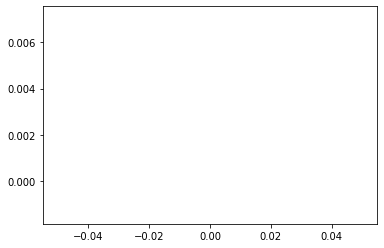